In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit

# Load and check data

In [2]:
PROCESSED_DATA_FOLDER = "data/4_all_data_preprocessed"
DATASET_FILE = "all_features"

In [3]:
# Load dataset
dataset = pickle.load(open(f"{PROCESSED_DATA_FOLDER}/{DATASET_FILE}.pkl", "rb"))

In [4]:
# Check the size of the data
dataset.shape

(192867, 760)

In [5]:
# Check preview the dataset
dataset.head()

,city_resolvedAddress,day_datetime,isw_date_tomorrow_datetime,event_indicator,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,...,isw_work,isw_would,isw_wound,isw_year,isw_yet,isw_yevgeni,isw_zaporizhia,isw_zaporizhzhia,isw_znpp,isw_zone
0,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
1,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
2,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
3,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
4,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0


In [6]:
# Check summary of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192867 entries, 0 to 192866
Columns: 760 entries, city_resolvedAddress to isw_zone
dtypes: Sparse[float64, 0](718), bool(1), float64(38), object(3)
memory usage: 841.3+ MB


In [7]:
dataset.dtypes

city_resolvedAddress                      object
day_datetime                              object
isw_date_tomorrow_datetime                object
event_indicator                             bool
day_tempmax                              float64
                                     ...        
isw_yevgeni                   Sparse[float64, 0]
isw_zaporizhia                Sparse[float64, 0]
isw_zaporizhzhia              Sparse[float64, 0]
isw_znpp                      Sparse[float64, 0]
isw_zone                      Sparse[float64, 0]
Length: 760, dtype: object

In [8]:
# Check nan
dataset.isna().sum()

city_resolvedAddress          0
day_datetime                  0
isw_date_tomorrow_datetime    0
event_indicator               0
day_tempmax                   0
                             ..
isw_yevgeni                   0
isw_zaporizhia                0
isw_zaporizhzhia              0
isw_znpp                      0
isw_zone                      0
Length: 760, dtype: int64

In [9]:
# Sort dataset by date
dataset['day_datetime'] = pd.to_datetime(dataset['day_datetime'])
dataset = dataset.sort_values(by='day_datetime')
dataset.day_datetime.describe(datetime_is_numeric=True)

count                           192867
mean     2022-08-02 23:32:38.163916288
min                2022-02-25 00:00:00
25%                2022-05-10 00:00:00
50%                2022-08-02 00:00:00
75%                2022-10-24 00:00:00
max                2023-01-20 00:00:00
Name: day_datetime, dtype: object

In [10]:
# Extract relevant date features
dataset['year'] = dataset['day_datetime'].dt.year
dataset['month'] = dataset['day_datetime'].dt.month
dataset['day'] = dataset['day_datetime'].dt.day
dataset['day_of_week'] = dataset['day_datetime'].dt.dayofweek

dataset['season'] = (dataset['day_datetime'].dt.month % 12 // 3).replace({0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'})

dataset = pd.get_dummies(dataset, columns=['season'])

In [11]:
# Translate city names
dataset.rename(columns = {'city_resolvedAddress':'city'}, inplace=True)
dataset['city'].unique()

array(['Луцьк, Луцький район, Україна', 'Житомир, Україна',
       'Рівне, Україна', 'Полтава, Україна', 'Тернопіль, Україна',
       'Ужгород, Ужгородський район, Україна', 'Донецьк, Україна',
       'Запоріжжя, Україна', 'Суми, Україна', 'Черкаси, Україна',
       'Вінниця, Україна', 'Львів, Україна', 'Івано-Франківськ, Україна',
       'Херсон, Україна', 'Київ, Україна', 'Дніпро, Україна',
       'Чернівці, Україна', 'Кропивницький, Україна', 'Харків, Україна',
       'Миколаїв, Україна', 'Хмельницька область, Україна',
       'Одеса, Україна', 'Чернігів, Україна'], dtype=object)

In [12]:
region_dict = {
    "Київ, Україна" : 'Kyiv', 
    "Миколаїв, Україна" : 'Mykolaiv',
    "Дніпро, Україна": 'Dnipro',
    "Харків, Україна" : 'Kharkiv', 
    "Житомир, Україна": 'Zhytomyr',
    "Кропивницький, Україна": 'Kropyvnytskyi',
    "Запоріжжя, Україна": 'Zaporizhzhia',
    "Полтава, Україна": 'Poltava',
    "Чернігів, Україна": 'Chernihiv',
    "Одеса, Україна": 'Odesa',
    "Хмельницька область, Україна": 'Khmelnytskyi',
    "Черкаси, Україна": 'Cherkasy',
    "Суми, Україна": 'Sumy',
    "Вінниця, Україна": 'Vinnytsia',
    "Херсон, Україна": 'Kherson',
    "Львів, Україна": 'Lviv',
    "Луцьк, Луцький район, Україна": 'Lutsk',
    "Рівне, Україна": 'Rivne',
    "Івано-Франківськ, Україна": 'Ivano-Frankivsk',
    "Тернопіль, Україна": 'Ternopil',
    "Чернівці, Україна": 'Chernivtsi',
    "Ужгород, Ужгородський район, Україна": 'Uzhhorod',
    "Донецьк, Україна": 'Donetsk'
}

dataset = dataset.replace({"city": region_dict})

In [13]:
# Define target variable
dataset['target'] = dataset['event_indicator']
dataset = dataset.drop(columns=['event_indicator', 'isw_date_tomorrow_datetime'])

# check distribution of target column
dataset['target'] = dataset['target'].astype(int)
dataset['target'].value_counts()

0    143773
1     49094
Name: target, dtype: int64

In [14]:
# check the percentage distribution of target column
dataset['target'].value_counts()/(len(dataset))

0    0.745452
1    0.254548
Name: target, dtype: float64

[Text(0.5, 1.0, 'Countplot of events')]

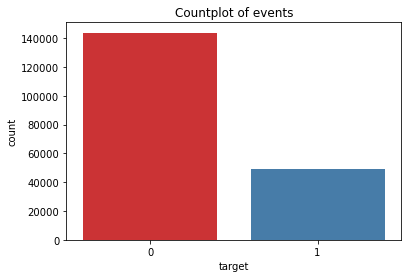

In [15]:
np.float = float
sns.countplot(x='target', data=dataset, palette='Set1').set(title = "Countplot of events")

Text(0, 0.5, 'Number of Air alerts')

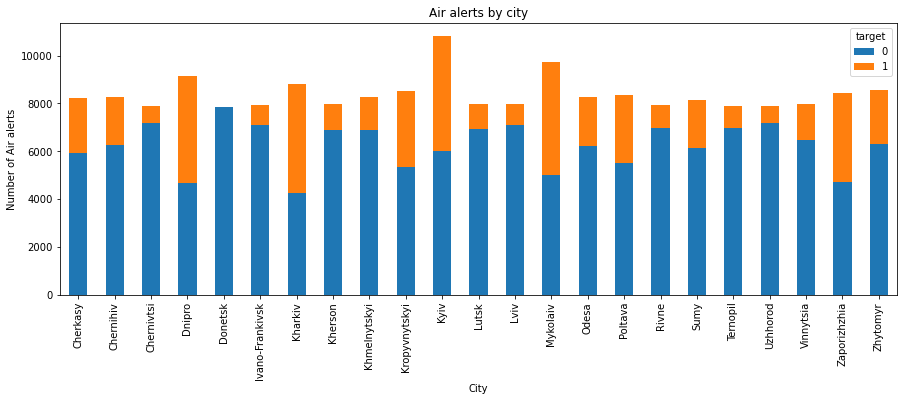

In [16]:
#%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
pd.crosstab(dataset['city'], dataset['target']).plot(kind='bar', stacked=True)
plt.title('Air alerts by city')
plt.xlabel('City')
plt.ylabel('Number of Air alerts')

In [17]:
# Create id column for each unique city
cities = dataset['city'].unique()
city_dict = {cities[i]: i+1 for i in range(len(cities))}
dataset['city_id'] = dataset['city'].map(city_dict)
dataset.drop('city', axis=1, inplace=True)

# Model Selection

In [18]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(random_state=5, class_weight="balanced", verbose=True)

# Support Vector Machines - Poor performance
# from sklearn.svm import SVC
# models['Support Vector Machines'] = SVC(random_state=5, class_weight="balanced", verbose=True)

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
models['Stochastic Gradient Descent'] = SGDClassifier(random_state=5, class_weight="balanced", loss="log", verbose=True)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(random_state=5, class_weight="balanced", verbose=True)

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
models['AdaBoost'] = AdaBoostClassifier(random_state=5)


# XGBoost
from xgboost import XGBClassifier
models['XGBoost'] = XGBClassifier(random_state=5, objective='binary:logistic', booster='gbtree', verbose=2)

# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['KNN'] = KNeighborsClassifier(n_neighbors=7)

In [19]:
models

{'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=5, verbose=True),
 'Stochastic Gradient Descent': SGDClassifier(class_weight='balanced', loss='log', random_state=5, verbose=True),
 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=5, verbose=True),
 'AdaBoost': AdaBoostClassifier(random_state=5),
 'XGBoost': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constr

In [20]:
# Save the models to disk
for model_name in models.keys():
    filename = f'model/6__{model_name}__v0.pkl'
    pickle.dump(models[model_name], open(filename, 'wb'))
    print(f"{filename} saved")

model/6__Logistic Regression__v0.pkl saved
model/6__Stochastic Gradient Descent__v0.pkl saved
model/6__Random Forest__v0.pkl saved
model/6__AdaBoost__v0.pkl saved
model/6__XGBoost__v0.pkl saved
model/6__KNN__v0.pkl saved


# Model Training

In [21]:
min_date = dataset['day_datetime'].min()
max_date = dataset['day_datetime'].max()
print("Min:", min_date, "Max:", max_date)

Min: 2022-02-25 00:00:00 Max: 2023-01-20 00:00:00


In [22]:
train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Timestamp('2022-10-29 18:00:00')

In [23]:
train_df = dataset[dataset['day_datetime'] <= train_cutoff]
test_df = dataset[dataset['day_datetime'] > train_cutoff]

In [24]:
# Split the dataset into features (X) and target (y)
X_train, X_test = train_df.drop(columns=['target', 'day_datetime']), test_df.drop(columns=['target', 'day_datetime'])
y_train, y_test = train_df['target'], test_df['target']

In [25]:
# Train models
predict_dict, predict_proba_dict = {}, {}

for key in models.keys():
    print(key)

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predict_dict[key] = models[key].predict(X_test)
    predict_proba_dict[key] = models[key].predict_proba(X_test)[:, 1]

Logistic Regression


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.3s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\valida

Stochastic Gradient Descent


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


-- Epoch 1
Norm: 101486.52, NNZs: 765, Bias: 213.293721, T: 147734, Avg. loss: 663679919.048180
Total training time: 0.69 seconds.
-- Epoch 2
Norm: 97812.50, NNZs: 765, Bias: 240.093881, T: 295468, Avg. loss: 89534915.843517
Total training time: 1.53 seconds.
-- Epoch 3
Norm: 93046.41, NNZs: 765, Bias: 253.943407, T: 443202, Avg. loss: 51537038.516701
Total training time: 2.24 seconds.
-- Epoch 4
Norm: 89413.18, NNZs: 765, Bias: 263.178806, T: 590936, Avg. loss: 36634669.862893
Total training time: 2.92 seconds.
-- Epoch 5
Norm: 85875.24, NNZs: 765, Bias: 269.710516, T: 738670, Avg. loss: 27986337.653683
Total training time: 3.49 seconds.
-- Epoch 6
Norm: 82640.96, NNZs: 765, Bias: 274.607890, T: 886404, Avg. loss: 22834912.258487
Total training time: 4.20 seconds.
-- Epoch 7
Norm: 79893.00, NNZs: 765, Bias: 278.569834, T: 1034138, Avg. loss: 19071048.050204
Total training time: 4.89 seconds.
-- Epoch 8
Norm: 77196.72, NNZs: 765, Bias: 281.685742, T: 1181872, Avg. loss: 16438931.345362

Norm: 27353.23, NNZs: 765, Bias: 300.439104, T: 9454976, Avg. loss: 1785567.870799
Total training time: 45.70 seconds.
-- Epoch 65
Norm: 27127.36, NNZs: 765, Bias: 300.447772, T: 9602710, Avg. loss: 1755463.097828
Total training time: 46.41 seconds.
-- Epoch 66
Norm: 26921.68, NNZs: 765, Bias: 300.464796, T: 9750444, Avg. loss: 1730898.539829
Total training time: 47.00 seconds.
-- Epoch 67
Norm: 26712.69, NNZs: 765, Bias: 300.474066, T: 9898178, Avg. loss: 1713998.988599
Total training time: 47.59 seconds.
-- Epoch 68
Norm: 26498.36, NNZs: 765, Bias: 300.478286, T: 10045912, Avg. loss: 1679968.963016
Total training time: 48.20 seconds.
-- Epoch 69
Norm: 26296.86, NNZs: 765, Bias: 300.482240, T: 10193646, Avg. loss: 1653182.128860
Total training time: 48.73 seconds.
-- Epoch 70
Norm: 26091.42, NNZs: 765, Bias: 300.480881, T: 10341380, Avg. loss: 1628234.448639
Total training time: 49.29 seconds.
-- Epoch 71
Norm: 25901.03, NNZs: 765, Bias: 300.483401, T: 10489114, Avg. loss: 1606577.058

Norm: 20525.08, NNZs: 765, Bias: 300.485981, T: 18614484, Avg. loss: 884631.832453
Total training time: 86.36 seconds.
-- Epoch 127
Norm: 20470.58, NNZs: 765, Bias: 300.480415, T: 18762218, Avg. loss: 878041.460563
Total training time: 86.98 seconds.
-- Epoch 128
Norm: 20425.28, NNZs: 765, Bias: 300.481326, T: 18909952, Avg. loss: 867371.774350
Total training time: 87.58 seconds.
-- Epoch 129
Norm: 20381.29, NNZs: 765, Bias: 300.481319, T: 19057686, Avg. loss: 857202.505854
Total training time: 88.22 seconds.
-- Epoch 130
Norm: 20340.03, NNZs: 765, Bias: 300.484632, T: 19205420, Avg. loss: 853896.151380
Total training time: 88.82 seconds.
-- Epoch 131
Norm: 20296.29, NNZs: 765, Bias: 300.483845, T: 19353154, Avg. loss: 843606.351504
Total training time: 89.41 seconds.
-- Epoch 132
Norm: 20257.13, NNZs: 765, Bias: 300.487595, T: 19500888, Avg. loss: 842315.667689
Total training time: 90.04 seconds.
-- Epoch 133
Norm: 20212.22, NNZs: 765, Bias: 300.484701, T: 19648622, Avg. loss: 837482.

Norm: 18653.94, NNZs: 765, Bias: 300.496365, T: 27773992, Avg. loss: 577019.822905
Total training time: 124.96 seconds.
-- Epoch 189
Norm: 18633.43, NNZs: 765, Bias: 300.494948, T: 27921726, Avg. loss: 572590.417337
Total training time: 125.56 seconds.
-- Epoch 190
Norm: 18614.13, NNZs: 765, Bias: 300.493689, T: 28069460, Avg. loss: 570901.618076
Total training time: 126.26 seconds.
-- Epoch 191
Norm: 18593.70, NNZs: 765, Bias: 300.491320, T: 28217194, Avg. loss: 570253.189762
Total training time: 126.94 seconds.
-- Epoch 192
Norm: 18574.48, NNZs: 765, Bias: 300.492362, T: 28364928, Avg. loss: 562382.438957
Total training time: 127.52 seconds.
-- Epoch 193
Norm: 18554.12, NNZs: 765, Bias: 300.490195, T: 28512662, Avg. loss: 560726.481841
Total training time: 128.13 seconds.
-- Epoch 194
Norm: 18534.46, NNZs: 765, Bias: 300.489553, T: 28660396, Avg. loss: 555465.049753
Total training time: 128.72 seconds.
-- Epoch 195
Norm: 18518.21, NNZs: 765, Bias: 300.492347, T: 28808130, Avg. loss: 

Norm: 17712.02, NNZs: 765, Bias: 300.478145, T: 36933500, Avg. loss: 419457.095870
Total training time: 164.97 seconds.
-- Epoch 251
Norm: 17702.81, NNZs: 765, Bias: 300.480489, T: 37081234, Avg. loss: 421779.680550
Total training time: 165.59 seconds.
-- Epoch 252
Norm: 17688.81, NNZs: 765, Bias: 300.477776, T: 37228968, Avg. loss: 417995.013500
Total training time: 166.16 seconds.
-- Epoch 253
Norm: 17677.74, NNZs: 765, Bias: 300.477594, T: 37376702, Avg. loss: 417405.635590
Total training time: 166.86 seconds.
-- Epoch 254
Norm: 17667.62, NNZs: 765, Bias: 300.479420, T: 37524436, Avg. loss: 415404.589393
Total training time: 167.43 seconds.
-- Epoch 255
Norm: 17656.06, NNZs: 765, Bias: 300.479048, T: 37672170, Avg. loss: 413974.564128
Total training time: 168.06 seconds.
-- Epoch 256
Norm: 17644.82, NNZs: 765, Bias: 300.479578, T: 37819904, Avg. loss: 411432.383826
Total training time: 168.70 seconds.
-- Epoch 257
Norm: 17633.33, NNZs: 765, Bias: 300.479118, T: 37967638, Avg. loss: 

Norm: 17096.65, NNZs: 765, Bias: 300.467418, T: 46093008, Avg. loss: 330451.318744
Total training time: 202.02 seconds.
-- Epoch 313
Norm: 17087.74, NNZs: 765, Bias: 300.466172, T: 46240742, Avg. loss: 329218.235027
Total training time: 202.59 seconds.
-- Epoch 314
Norm: 17080.08, NNZs: 765, Bias: 300.467036, T: 46388476, Avg. loss: 330483.276332
Total training time: 203.20 seconds.
-- Epoch 315
Norm: 17071.47, NNZs: 765, Bias: 300.466090, T: 46536210, Avg. loss: 327556.923118
Total training time: 203.82 seconds.
-- Epoch 316
Norm: 17063.93, NNZs: 765, Bias: 300.466441, T: 46683944, Avg. loss: 324691.335946
Total training time: 204.57 seconds.
-- Epoch 317
Norm: 17054.77, NNZs: 765, Bias: 300.464306, T: 46831678, Avg. loss: 326189.715224
Total training time: 205.27 seconds.
-- Epoch 318
Norm: 17046.22, NNZs: 765, Bias: 300.463457, T: 46979412, Avg. loss: 323650.492714
Total training time: 205.86 seconds.
-- Epoch 319
Norm: 17038.37, NNZs: 765, Bias: 300.463549, T: 47127146, Avg. loss: 

Norm: 16630.43, NNZs: 765, Bias: 300.465962, T: 55252516, Avg. loss: 270761.208136
Total training time: 240.93 seconds.
-- Epoch 375
Norm: 16624.38, NNZs: 765, Bias: 300.466346, T: 55400250, Avg. loss: 269583.222042
Total training time: 241.51 seconds.
-- Epoch 376
Norm: 16617.91, NNZs: 765, Bias: 300.466570, T: 55547984, Avg. loss: 269625.742343
Total training time: 242.09 seconds.
-- Epoch 377
Norm: 16609.95, NNZs: 765, Bias: 300.465119, T: 55695718, Avg. loss: 265407.485078
Total training time: 242.64 seconds.
-- Epoch 378
Norm: 16603.44, NNZs: 765, Bias: 300.464976, T: 55843452, Avg. loss: 267239.409901
Total training time: 243.20 seconds.
-- Epoch 379
Norm: 16596.86, NNZs: 765, Bias: 300.464436, T: 55991186, Avg. loss: 267350.392119
Total training time: 243.79 seconds.
-- Epoch 380
Norm: 16590.36, NNZs: 765, Bias: 300.464918, T: 56138920, Avg. loss: 264939.545032
Total training time: 244.41 seconds.
-- Epoch 381
Norm: 16583.46, NNZs: 765, Bias: 300.464438, T: 56286654, Avg. loss: 

Norm: 16243.34, NNZs: 765, Bias: 300.462201, T: 64412024, Avg. loss: 226929.768607
Total training time: 279.63 seconds.
-- Epoch 437
Norm: 16237.19, NNZs: 765, Bias: 300.461894, T: 64559758, Avg. loss: 226125.606399
Total training time: 280.31 seconds.
-- Epoch 438
Norm: 16231.47, NNZs: 765, Bias: 300.462493, T: 64707492, Avg. loss: 224732.897904
Total training time: 280.92 seconds.
-- Epoch 439
Norm: 16225.62, NNZs: 765, Bias: 300.461993, T: 64855226, Avg. loss: 224800.822667
Total training time: 281.55 seconds.
-- Epoch 440
Norm: 16219.58, NNZs: 765, Bias: 300.461642, T: 65002960, Avg. loss: 224381.897043
Total training time: 282.19 seconds.
-- Epoch 441
Norm: 16214.10, NNZs: 765, Bias: 300.463093, T: 65150694, Avg. loss: 223791.516106
Total training time: 282.82 seconds.
-- Epoch 442
Norm: 16207.96, NNZs: 765, Bias: 300.462344, T: 65298428, Avg. loss: 222570.080871
Total training time: 283.46 seconds.
-- Epoch 443
Norm: 16202.72, NNZs: 765, Bias: 300.463670, T: 65446162, Avg. loss: 

Norm: 15902.94, NNZs: 765, Bias: 300.460333, T: 73571532, Avg. loss: 196187.582033
Total training time: 318.92 seconds.
-- Epoch 499
Norm: 15897.06, NNZs: 765, Bias: 300.459107, T: 73719266, Avg. loss: 193667.385916
Total training time: 319.52 seconds.
-- Epoch 500
Norm: 15891.56, NNZs: 765, Bias: 300.458313, T: 73867000, Avg. loss: 193754.101778
Total training time: 320.13 seconds.
-- Epoch 501
Norm: 15886.51, NNZs: 765, Bias: 300.457905, T: 74014734, Avg. loss: 193789.382538
Total training time: 320.91 seconds.
-- Epoch 502
Norm: 15881.44, NNZs: 765, Bias: 300.457525, T: 74162468, Avg. loss: 192699.447006
Total training time: 321.50 seconds.
-- Epoch 503
Norm: 15876.70, NNZs: 765, Bias: 300.458563, T: 74310202, Avg. loss: 191823.687107
Total training time: 322.15 seconds.
-- Epoch 504
Norm: 15870.97, NNZs: 765, Bias: 300.457376, T: 74457936, Avg. loss: 191757.125409
Total training time: 322.79 seconds.
-- Epoch 505
Norm: 15865.53, NNZs: 765, Bias: 300.457550, T: 74605670, Avg. loss: 

C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Random Forest


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.4min finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend Se

AdaBoost


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


XGBoost
[09:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

KNN


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# Model Evaluation

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import matthews_corrcoef
from scikitplot.helpers import binary_ks_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [27]:
accuracy, precision, recall, f1, auc, pr_auc, loss, b_loss, ks_stat, matthews_corr = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predict_dict[key])
    precision[key] = precision_score(y_test, predict_dict[key])
    recall[key] = recall_score(y_test, predict_dict[key])
    f1[key] = f1_score(y_test, predict_dict[key])
    auc[key] = roc_auc_score(y_test, predict_proba_dict[key])
    pr_auc[key] = average_precision_score(y_test, predict_proba_dict[key])
    loss[key] = log_loss(y_test, predict_proba_dict[key])
    b_loss[key] = brier_score_loss(y_test, predict_proba_dict[key])
    ks_stat[key] =  binary_ks_curve(y_test, predict_proba_dict[key])[3]
    matthews_corr[key] = matthews_corrcoef(y_test, predict_dict[key])
    
columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'Log loss', 'Brier score', 'KS', 'MCC']   
df_model = pd.DataFrame(index=models.keys(), columns=columns)

df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model['ROC AUC'] = auc.values()
df_model['PR AUC'] = pr_auc.values()
df_model['Log loss'] = loss.values()
df_model['Brier score'] = b_loss.values()
df_model['KS'] = ks_stat.values()
df_model['MCC'] = matthews_corr.values()

df_model

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC,Log loss,Brier score,KS,MCC
Logistic Regression,0.603173,0.276047,0.916539,0.424301,0.814560,0.399207,0.714755,0.250870,0.495720,0.337655
Stochastic Gradient Descent,0.837591,0.461584,0.107624,0.174550,0.542645,0.192640,5.853520,0.162409,0.085393,0.162129
Random Forest,0.842599,0.821192,0.017220,0.033732,0.930593,0.724399,0.304765,0.090708,0.782437,0.104686
AdaBoost,0.920036,0.754391,0.739619,0.746932,0.956586,0.838153,0.640472,0.223718,0.844097,0.699502
XGBoost,0.915827,0.774443,0.666574,0.716471,0.960518,0.799026,0.314300,0.071240,0.828404,0.669962
KNN,0.762901,0.156053,0.110262,0.129221,0.477688,0.157233,3.537876,0.192079,0.002374,-0.003404


Confusion matrix for Logistic Regression


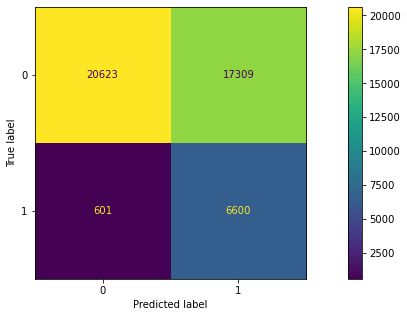

Confusion matrix for Stochastic Gradient Descent


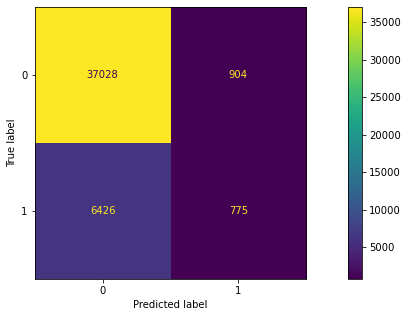

Confusion matrix for Random Forest


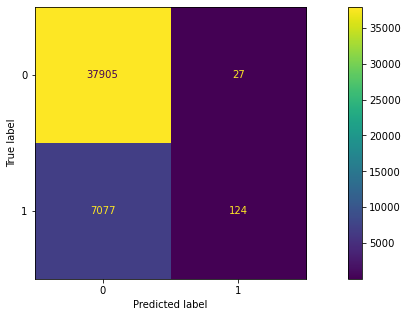

Confusion matrix for AdaBoost


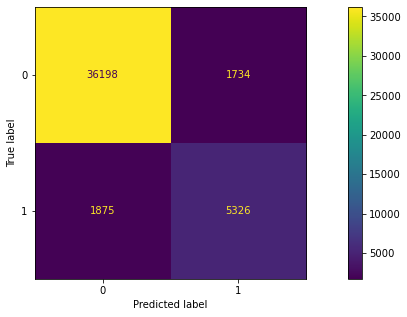

Confusion matrix for XGBoost


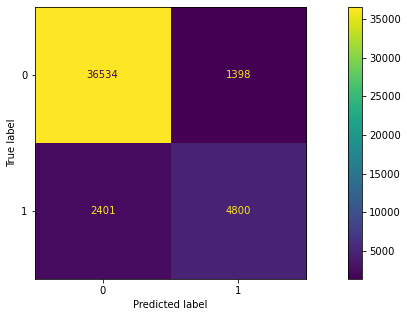

Confusion matrix for KNN


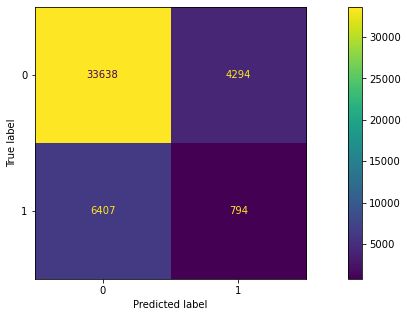

In [28]:
# Generate confusion matrix plots
for key in models.keys():
    print(f"Confusion matrix for {key}")
    
    matrix = confusion_matrix(y_test, predict_dict[key])
    cm = confusion_matrix(y_test, predict_dict[key], labels=models[key].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[key].classes_)
    disp.plot()
    plt.show()

In [29]:
for key in models.keys():
    print(f"Classification report for {key}")
    print(classification_report(y_test, predict_dict[key]))
    print("=====================================================")

Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.54      0.70     37932
           1       0.28      0.92      0.42      7201

    accuracy                           0.60     45133
   macro avg       0.62      0.73      0.56     45133
weighted avg       0.86      0.60      0.65     45133

Classification report for Stochastic Gradient Descent
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     37932
           1       0.46      0.11      0.17      7201

    accuracy                           0.84     45133
   macro avg       0.66      0.54      0.54     45133
weighted avg       0.79      0.84      0.79     45133

Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     37932
           1       0.82      0.02      0.03      7201

    accuracy                           0.8

In [28]:
# ROC curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

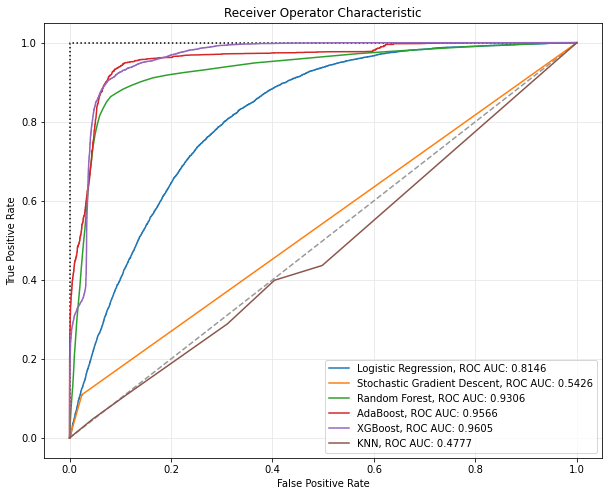

In [29]:
#set up plotting area
plt.rcParams["figure.figsize"] = [10, 8]
plt.figure(0).clf()

# roc curve for random and perfect models
plt.plot([0, 1], [0, 1], linestyle = '--', color = (0.6, 0.6, 0.6))
plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'black')

for key in models.keys():
    fpr, tpr, thresholds = roc_curve(y_test, predict_proba_dict[key])
    auc = round(roc_auc_score(y_test, predict_proba_dict[key]), 4)
    plt.plot(fpr, tpr, label=f"{key}, ROC AUC: {auc}")
 

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic')
plt.grid(color='0.9')
plt.legend()

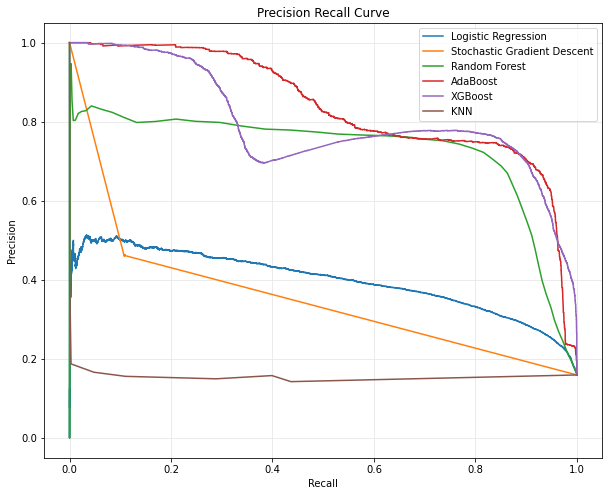

In [30]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#set up plotting area
plt.figure(0).clf()

for key in models.keys():
    precision, recall, thresholds = precision_recall_curve(y_test, predict_proba_dict[key])
    label = f'{key}'
    plt.plot(recall, precision, label = label)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')  
plt.ylabel('Precision')  
plt.title('Precision Recall Curve')
plt.grid(color='0.9')
plt.legend()

## Time-based cross-validation

In [31]:
from scipy import interp
from sklearn import metrics

from TimeBasedCV import *

In [32]:
tscv = TimeBasedCV(train_period=30, test_period=30)

In [33]:
for train_index, test_index in tscv.split(dataset, date_column='day_datetime'):
    print(train_index, test_index)

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

In [34]:
# get number of splits
tscv.get_n_splits()

9

In [35]:
selected_models = ['Logistic Regression', 'Random Forest', 'XGBoost']

In [36]:
X = dataset.drop(columns=['target'])
y = dataset['target']

### Logistic Regression

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\valida

C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
<ipython-input-37-278cd34ce318>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_

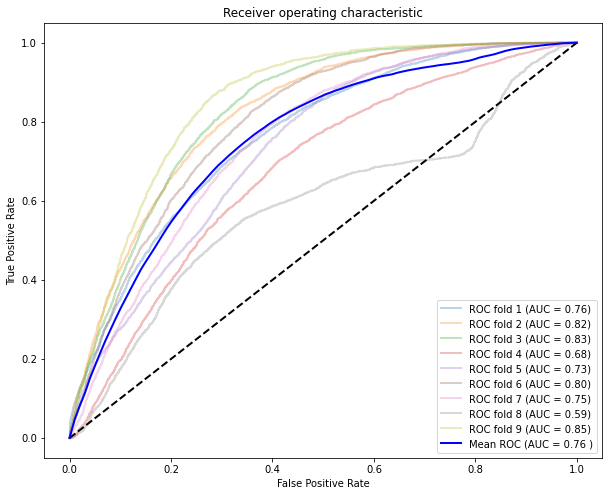

In [37]:
#### Compute average test sets score (AUC)
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []
i = 1
for train_index, test_index in tscv.split(X, date_column='day_datetime'):

    data_train   = X.loc[train_index].drop('day_datetime', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('day_datetime', axis=1)
    target_test  = y.loc[test_index]

    clf = models[selected_models[0]]
    clf.fit(data_train, target_train)

    probas_ = clf.predict_proba(data_test)[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i+=1

plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'black')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Random Forest

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.0s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
<ipython-input-46-e2325f4645e5>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\skl

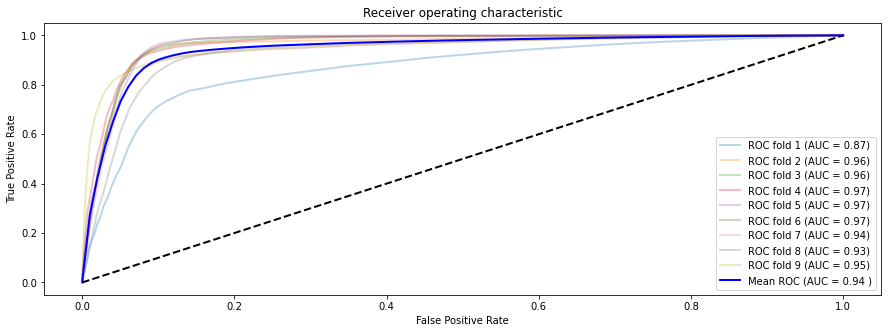

In [46]:
#### Compute average test sets score (AUC)
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []
i = 1
for train_index, test_index in tscv.split(X, date_column='day_datetime'):

    data_train   = X.loc[train_index].drop('day_datetime', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('day_datetime', axis=1)
    target_test  = y.loc[test_index]

    clf = models[selected_models[1]]
    clf.fit(data_train, target_train)

    probas_ = clf.predict_proba(data_test)[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i+=1

plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'black')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### XGBoost

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:42:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


[23:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



<ipython-input-47-a3ba7bdec997>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


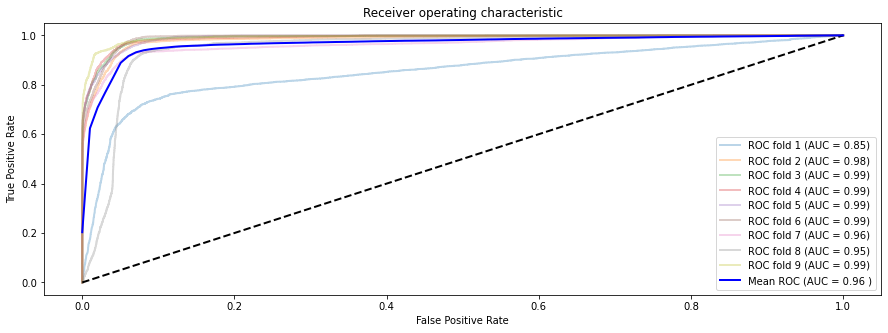

In [47]:
#### Compute average test sets score (AUC)
mean_fpr = np.linspace(0, 1, 100)

tprs = []
aucs = []
i = 1
for train_index, test_index in tscv.split(X, date_column='day_datetime'):

    data_train   = X.loc[train_index].drop('day_datetime', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('day_datetime', axis=1)
    target_test  = y.loc[test_index]

    clf = models[selected_models[2]]
    clf.fit(data_train, target_train)

    probas_ = clf.predict_proba(data_test)[:, 1]
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i+=1

plt.plot([0,1], [0,1], linestyle = '--', lw = 2, color = 'black')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Hyperparameter tuning

## Randomized grid search

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint, uniform

index_output = tscv.split(X, date_column='day_datetime')

Train period: 2022-02-25 - 2022-03-27 , Test period 2022-03-27 - 2022-04-26 # train records 21315 , # test records 18141
Train period: 2022-03-27 - 2022-04-26 , Test period 2022-04-26 - 2022-05-26 # train records 18141 , # test records 17677
Train period: 2022-04-26 - 2022-05-26 , Test period 2022-05-26 - 2022-06-25 # train records 17677 , # test records 17307
Train period: 2022-05-26 - 2022-06-25 , Test period 2022-06-25 - 2022-07-25 # train records 17307 , # test records 17214
Train period: 2022-06-25 - 2022-07-25 , Test period 2022-07-25 - 2022-08-24 # train records 17214 , # test records 17196
Train period: 2022-07-25 - 2022-08-24 , Test period 2022-08-24 - 2022-09-23 # train records 17196 , # test records 17452
Train period: 2022-08-24 - 2022-09-23 , Test period 2022-09-23 - 2022-10-23 # train records 17452 , # test records 17382
Train period: 2022-09-23 - 2022-10-23 , Test period 2022-10-23 - 2022-11-22 # train records 17382 , # test records 17053
Train period: 2022-10-23 - 2022-

In [30]:
params = {
 "learning_rate" : [0.1, 0.2, 0.3, 0.4],
 "max_depth" : [10, 12, 15],
 "min_child_weight" : [1, 3, 5, 7],
 "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
 "colsample_bytree" : [0.3, 0.5, 0.7]
}

In [32]:
xgb_clf = models['XGBoost']

In [41]:
model = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=params,
    n_iter=4,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True,
    cv=index_output,
    verbose=3,
    pre_dispatch='2*n_jobs',
    random_state=5,
    return_train_score=True)

In [42]:
model.fit(X.drop('day_datetime', axis=1), y)
model.cv_results_

Fitting 9 folds for each of 4 candidates, totalling 36 fits
[01:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



{'mean_fit_time': array([ 95.66748063, 219.39432478, 135.06467067, 159.89083529]),
 'std_fit_time': array([ 3.08552923, 22.56665837, 16.74763243, 33.26891484]),
 'mean_score_time': array([3.98012998, 5.69367684, 4.67082124, 2.04018458]),
 'std_score_time': array([1.66485592, 2.49795398, 1.54696854, 1.14317903]),
 'param_min_child_weight': masked_array(data=[5, 3, 5, 1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 12, 15, 12],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.2, 0.3, 0.2, 0.2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.4, 0.4, 0.2, 0.3],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_colsample_bytree': masked_array(data=[0

In [70]:
print('\n All results:')
print(model.cv_results_)

print('\n Best estimator:')
print(model.best_estimator_)

print('\n Best hyperparameters:')
print(model.best_params_)

print("\n The best score across:")
print(model.best_score_)

results = pd.DataFrame(model.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([ 95.66748063, 219.39432478, 135.06467067, 159.89083529]), 'std_fit_time': array([ 3.08552923, 22.56665837, 16.74763243, 33.26891484]), 'mean_score_time': array([3.98012998, 5.69367684, 4.67082124, 2.04018458]), 'std_score_time': array([1.66485592, 2.49795398, 1.54696854, 1.14317903]), 'param_min_child_weight': masked_array(data=[5, 3, 5, 1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[10, 12, 15, 12],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.2, 0.3, 0.2, 0.2],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.4, 0.4, 0.2, 0.3],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.3, 0

In [50]:
#Building final classifier model
classifier = XGBClassifier(min_child_weight=1,
                           max_depth=12,
                           learning_rate=0.2,
                           gamma=0.3,
                           colsample_bytree=0.5,
                           objective='binary:logistic',
                           random_state=5, 
                           verbosity=3)

classifier.fit(X.drop('day_datetime', axis=1), y)

[04:03:46] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[04:03:52] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1470 extra nodes, 30 pruned nodes, max_depth=12
[04:03:55] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1280 extra nodes, 18 pruned nodes, max_depth=12
[04:03:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1308 extra nodes, 36 pruned nodes, max_depth=12
[04:04:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tre

[04:05:51] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 1034 extra nodes, 128 pruned nodes, max_depth=12
[04:05:54] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 992 extra nodes, 184 pruned nodes, max_depth=12
[04:05:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 882 extra nodes, 86 pruned nodes, max_depth=12
[04:06:00] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 946 extra nodes, 152 pruned nodes, max_depth=12
[04:06:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-075

[04:07:54] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 550 extra nodes, 166 pruned nodes, max_depth=12
[04:07:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 384 extra nodes, 108 pruned nodes, max_depth=12
[04:08:00] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 198 pruned nodes, max_depth=12
[04:08:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 140 pruned nodes, max_depth=12
[04:08:06] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-075

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=5, ...)

In [51]:
filename = f'model/6__XGBoost__v1.pkl'
pickle.dump(classifier, open(filename, 'wb'))
print(f"{filename} saved")

model/6__XGBoost__v1.pkl saved


## Cross Validation

In [48]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(classifier, X.drop('day_datetime', axis=1), y, cv=index_output, scoring="roc_auc", verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[01:17:57] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[01:17:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 484 extra nodes, 26 pruned nodes, max_depth=12
[01:17:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 362 extra nodes, 20 pruned nodes, max_depth=12
[01:17:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 22 pruned nodes, max_depth=12
[01:17:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\u

[01:18:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 132 extra nodes, 36 pruned nodes, max_depth=12
[01:18:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 136 extra nodes, 114 pruned nodes, max_depth=12
[01:18:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 210 extra nodes, 84 pruned nodes, max_depth=12
[01:18:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 170 extra nodes, 156 pruned nodes, max_depth=12
[01:18:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593

[01:18:12] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 42 extra nodes, 54 pruned nodes, max_depth=12
[01:18:12] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 62 extra nodes, 84 pruned nodes, max_depth=12
[01:18:12] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 64 pruned nodes, max_depth=12
[01:18:13] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 50 extra nodes, 96 pruned nodes, max_depth=12
[01:18:13] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91c

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.2s remaining:    0.0s


[01:18:22] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[01:18:22] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 522 extra nodes, 10 pruned nodes, max_depth=12
[01:18:22] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 284 extra nodes, 10 pruned nodes, max_depth=12
[01:18:22] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 316 extra nodes, 22 pruned nodes, max_depth=12
[01:18:22] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\u

[01:18:37] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 48 extra nodes, 88 pruned nodes, max_depth=10
[01:18:37] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 30 extra nodes, 114 pruned nodes, max_depth=10
[01:18:37] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 44 extra nodes, 94 pruned nodes, max_depth=8
[01:18:37] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 48 extra nodes, 68 pruned nodes, max_depth=12
[01:18:38] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91c

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.2s remaining:    0.0s


[01:18:45] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[01:18:46] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 8 pruned nodes, max_depth=12
[01:18:46] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 268 extra nodes, 4 pruned nodes, max_depth=12
[01:18:46] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 338 extra nodes, 12 pruned nodes, max_depth=12
[01:18:46] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\upd

[01:18:52] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 192 extra nodes, 84 pruned nodes, max_depth=12
[01:18:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 174 extra nodes, 126 pruned nodes, max_depth=12
[01:18:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 28 pruned nodes, max_depth=12
[01:18:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 138 extra nodes, 120 pruned nodes, max_depth=12
[01:18:53] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593

[01:18:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 46 extra nodes, 78 pruned nodes, max_depth=10
[01:18:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 44 extra nodes, 84 pruned nodes, max_depth=8
[01:18:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 50 extra nodes, 62 pruned nodes, max_depth=11
[01:18:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 52 extra nodes, 70 pruned nodes, max_depth=10
[01:19:00] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd

[01:19:09] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 290 extra nodes, 20 pruned nodes, max_depth=12
[01:19:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 716 extra nodes, 124 pruned nodes, max_depth=12
[01:19:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 332 extra nodes, 38 pruned nodes, max_depth=12
[01:19:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 34 pruned nodes, max_depth=12
[01:19:11] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593f

[01:19:24] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 40 extra nodes, 42 pruned nodes, max_depth=11
[01:19:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 38 extra nodes, 62 pruned nodes, max_depth=9
[01:19:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 26 extra nodes, 62 pruned nodes, max_depth=11
[01:19:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 0 extra nodes, 100 pruned nodes, max_depth=0
[01:19:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9

[01:19:36] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 284 extra nodes, 50 pruned nodes, max_depth=12
[01:19:36] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 138 pruned nodes, max_depth=12
[01:19:36] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 198 extra nodes, 30 pruned nodes, max_depth=12
[01:19:37] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 342 extra nodes, 124 pruned nodes, max_depth=12
[01:19:37] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593

[01:19:43] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 46 extra nodes, 90 pruned nodes, max_depth=11
[01:19:43] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 28 extra nodes, 82 pruned nodes, max_depth=9
[01:19:43] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 26 extra nodes, 114 pruned nodes, max_depth=6
[01:19:44] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 60 extra nodes, 42 pruned nodes, max_depth=12
[01:19:44] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd

[01:19:49] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 46 extra nodes, 34 pruned nodes, max_depth=12
[01:19:49] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 18 extra nodes, 56 pruned nodes, max_depth=9
[01:19:49] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 18 extra nodes, 44 pruned nodes, max_depth=9
[01:19:49] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 14 extra nodes, 60 pruned nodes, max_depth=5
[01:19:50] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9d

[01:19:58] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 346 extra nodes, 102 pruned nodes, max_depth=12
[01:19:58] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 258 extra nodes, 196 pruned nodes, max_depth=12
[01:19:58] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 276 extra nodes, 126 pruned nodes, max_depth=12
[01:19:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 166 extra nodes, 28 pruned nodes, max_depth=12
[01:19:59] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0759

[01:20:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 46 extra nodes, 64 pruned nodes, max_depth=10
[01:20:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 68 extra nodes, 38 pruned nodes, max_depth=12
[01:20:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 44 extra nodes, 86 pruned nodes, max_depth=11
[01:20:04] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 42 extra nodes, 34 pruned nodes, max_depth=12
[01:20:05] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91c

[01:20:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 8 extra nodes, 60 pruned nodes, max_depth=4
[01:20:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 32 extra nodes, 56 pruned nodes, max_depth=11
[01:20:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 20 extra nodes, 62 pruned nodes, max_depth=8
[01:20:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 24 extra nodes, 50 pruned nodes, max_depth=12
[01:20:10] ======== Monitor (0): Learner ========
[01:20:10] Configure: 0.000682s, 1 calls @ 682us


[01:20:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 40 extra nodes, 98 pruned nodes, max_depth=12
[01:20:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 36 extra nodes, 92 pruned nodes, max_depth=10
[01:20:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 52 extra nodes, 78 pruned nodes, max_depth=11
[01:20:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 62 extra nodes, 70 pruned nodes, max_depth=12
[01:20:25] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91c

[CV] END ................................ score: (test=0.968) total time=  19.4s
[01:20:35] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:157: Using tree method: 2
[01:20:35] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 28 pruned nodes, max_depth=12
[01:20:36] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 366 extra nodes, 14 pruned nodes, max_depth=12
[01:20:36] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 18 pruned nodes, max_depth=12
[01:20:36] INFO: C:\buildkite-agent\builds\buildkite-windows-

[01:20:42] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 148 extra nodes, 70 pruned nodes, max_depth=12
[01:20:42] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 148 extra nodes, 138 pruned nodes, max_depth=12
[01:20:42] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 54 pruned nodes, max_depth=12
[01:20:42] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 154 extra nodes, 126 pruned nodes, max_depth=12
[01:20:42] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593

[01:20:48] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 36 extra nodes, 76 pruned nodes, max_depth=11
[01:20:48] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 60 extra nodes, 72 pruned nodes, max_depth=12
[01:20:48] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 36 extra nodes, 76 pruned nodes, max_depth=12
[01:20:48] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 50 extra nodes, 74 pruned nodes, max_depth=10
[01:20:48] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91c

[01:20:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 220 extra nodes, 24 pruned nodes, max_depth=12
[01:20:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 244 extra nodes, 18 pruned nodes, max_depth=12
[01:20:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 560 extra nodes, 76 pruned nodes, max_depth=12
[01:20:57] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 292 extra nodes, 46 pruned nodes, max_depth=12
[01:20:58] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ff

[01:21:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 80 pruned nodes, max_depth=11
[01:21:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 62 extra nodes, 54 pruned nodes, max_depth=11
[01:21:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 36 extra nodes, 98 pruned nodes, max_depth=11
[01:21:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 26 extra nodes, 104 pruned nodes, max_depth=7
[01:21:03] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91c

[01:21:08] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 30 extra nodes, 50 pruned nodes, max_depth=7
[01:21:08] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 16 extra nodes, 62 pruned nodes, max_depth=5
[01:21:08] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 10 extra nodes, 64 pruned nodes, max_depth=5
[01:21:08] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 20 extra nodes, 52 pruned nodes, max_depth=5
[01:21:08] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.3min finished


In [49]:
print("ROC AUC: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

ROC AUC: 96.96% (3.65%)


## Cross Validation using XGBoost

In [54]:
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X.drop('day_datetime', axis=1), label=y)

In [65]:
from xgboost import cv

params = {"objective":"binary:logistic",
          'min_child_weight': 1, 
          'max_depth': 12, 
          'learning_rate': 0.2, 
          'gamma': 0.3, 
          'colsample_bytree': 0.5}

xgb_cv = cv(dtrain=data_dmatrix, params=params, num_boost_round=50, folds=index_output,
            early_stopping_rounds=e10, metrics="auc", as_pandas=True, seed=123)

In [71]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.995315,0.001045,0.940647,0.044304
1,0.997279,0.001077,0.929963,0.033820
2,0.998218,0.000915,0.932734,0.039119
3,0.998751,0.000725,0.936979,0.038670
4,0.999151,0.000625,0.941876,0.038614


In [67]:
print('running cross validation, with preprocessing function')

# used to return the preprocessed training, test data, and parameter
# we can use this to do weight rescale, etc.
# as a example, we try to set scale_pos_weight
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

xgb_cv = cv(dtrain=data_dmatrix, params=params, num_boost_round=50, folds=index_output,
            early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123, fpreproc=fpreproc)

running cross validation, with preprocessing function


In [72]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.995315,0.001045,0.940647,0.044304
1,0.997279,0.001077,0.929963,0.033820
2,0.998218,0.000915,0.932734,0.039119
3,0.998751,0.000725,0.936979,0.038670
4,0.999151,0.000625,0.941876,0.038614


## Feature importance

In [80]:
# feature importance
print(classifier.feature_importances_)
# plot
pyplot.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
pyplot.show()

[0.00112059 0.0010635  0.0036876  0.00057149 0.00041001 0.00038114
 0.00039002 0.00109297 0.00038076 0.0003921  0.0006811  0.00146418
 0.00065119 0.00087651 0.00038622 0.00038406 0.00049726 0.00035555
 0.00048223 0.00043651 0.00063673 0.00044393 0.00043822 0.00037342
 0.00043099 0.00041475 0.00045665 0.00036462 0.00074065 0.0006246
 0.00047833 0.00046774 0.00042179 0.00053105 0.03479543 0.00175227
 0.0264837  0.00164072 0.00068488 0.00155032 0.0012296  0.00086956
 0.00069833 0.00110697 0.00045864 0.00086855 0.00133021 0.00075688
 0.00056188 0.00090453 0.00063051 0.00062784 0.00087808 0.0012524
 0.00067678 0.00036916 0.00080605 0.00052588 0.0010457  0.00090375
 0.00060126 0.00596142 0.00095786 0.00087225 0.00077254 0.00217112
 0.00078548 0.00090354 0.00100047 0.00106325 0.00070754 0.0012178
 0.00171126 0.00205225 0.00083845 0.00055724 0.00047897 0.00095102
 0.00131462 0.00100207 0.00087765 0.00061591 0.0012202  0.00057133
 0.00160441 0.00079165 0.00094309 0.00083143 0.00085805 0.0021696

NameError: name 'pyplot' is not defined

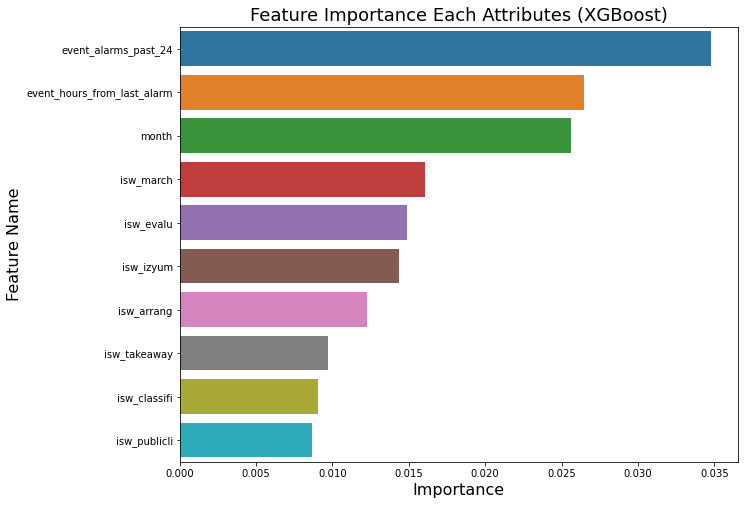

In [83]:
imp_df = pd.DataFrame({
    "Feature Name": X.drop('day_datetime', axis=1).columns,
    "Importance": classifier.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (XGBoost)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

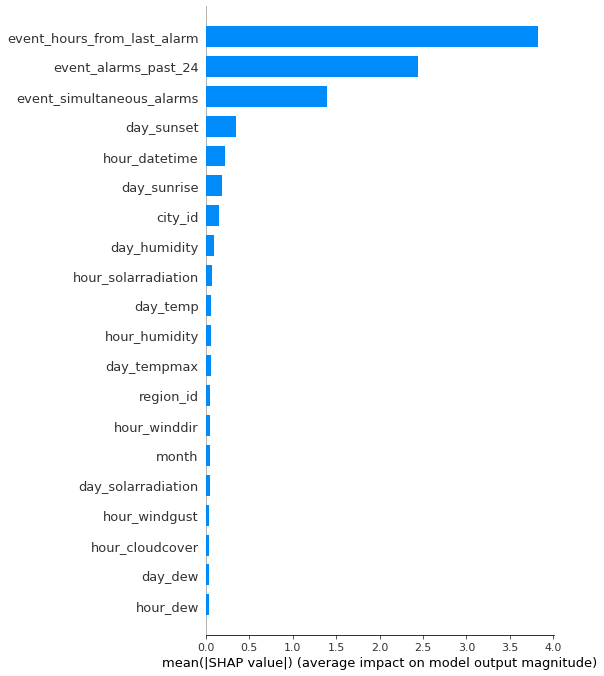

In [39]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


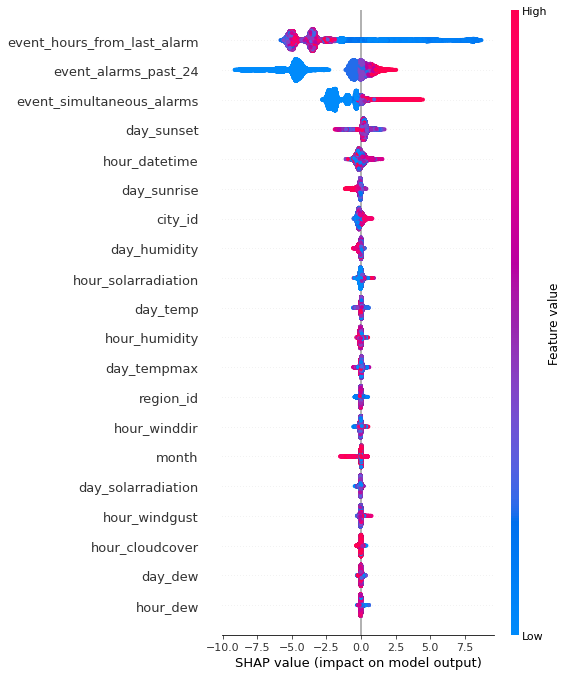

In [37]:
shap.summary_plot(shap_values, X_test)

100%|===================| 45119/45133 [10:45<00:00]        

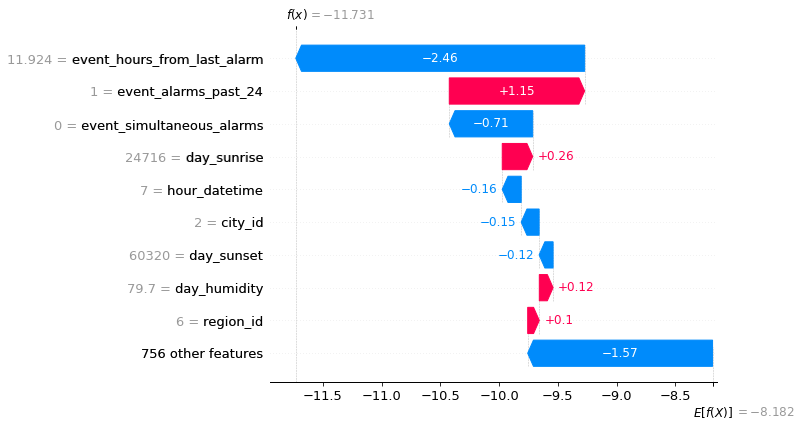

In [38]:
shap.plots.waterfall(shap_values[0])

In [47]:
# load JS visualization code to notebook
shap.initjs()

i = 30
shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i], feature_names=X_test.columns)

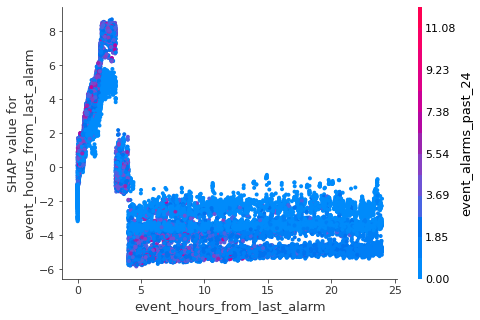

In [48]:
shap.dependence_plot("event_hours_from_last_alarm", shap_values, X_test)